In [1]:
import os
import sys
import ROOT
import pandas as pd
import numpy as np
import root_pandas
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, auc, roc_curve, accuracy_score, roc_auc_score

/Users/adsherman/miniconda2/envs/tZqAnalysis/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def TrainEval(train_DF, test_DF, var_list, n_estimators=150, max_depth=3, min_child_weight=1, seed=0):
    """ With training and testing DataFrame, and a list of variables with which to train and evaluate, produce the 
        score series for both the training and testing sets
    """
    
    # Create XGB object with the hyperparameters desired
    xgb = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth, 
                        min_child_weight=min_child_weight,
                        seed=seed)

    # Fit to the training set, making sure to include event weights
    xgb.fit(train_DF[var_list], # X
            train_DF["isSignal"], # yii
            sample_weight=train_DF["weight"], # weights
           )

    # Score the testing set
    y_score_test = xgb.predict_proba(test_DF[var_list])[:,1] # predict_proba returns [prob_bkg, prob_sig] which have the property prob_bkg+prob_sig = 1 so we only need one. Chose signal-ness
    
    # Score the training set (for overtraining analysis)
    y_score_train = xgb.predict_proba(train_DF[var_list])[:,1] # predict_proba returns [prob_bkg, prob_sig] which have the property prob_bkg+prob_sig = 1 so we only need one. Chose signal-ness
    
    # Cast the scores into pandas Series in order to connect their index to the source index
    y_score_test = pd.Series(y_score_test, index=test_DF.index) 
    y_score_train = pd.Series(y_score_train, index=train_DF.index) 
    
    return y_score_train, y_score_test

In [3]:
def PlotTemplate(train_DF, test_DF, y_score_train, y_score_test, norm=True):
    """ Using the source DataFrames and the score Series, plot the template histograms for the training and testing sets
    """
    
    plt.clf()
    plt.hist(y_score_test[test_DF["isSignal"] == 0], 
             weights=test_DF["weight"][test_DF["isSignal"] == 0] / (1.0 if not norm else sum(test_DF["weight"][test_DF["isSignal"] == 0])), 
             bins=10, range=(0,1), color="red", histtype="step", ls="-", label="test bkg")
    plt.hist(y_score_test[test_DF["isSignal"] == 1], 
             weights=test_DF["weight"][test_DF["isSignal"] == 1] / (1.0 if not norm else sum(test_DF["weight"][test_DF["isSignal"] == 1])), 
             bins=10, range=(0,1), color="blue", histtype="step", ls="-", label="test sig")
    plt.hist(y_score_train[train_DF["isSignal"] == 0], 
             weights=train_DF["weight"][train_DF["isSignal"] == 0] / (1.0 if not norm else sum(train_DF["weight"][train_DF["isSignal"] == 0])), 
             bins=10, range=(0,1), color="red", histtype="step", ls="--", label="train bkg")
    plt.hist(y_score_train[train_DF["isSignal"] == 1], 
             weights=train_DF["weight"][train_DF["isSignal"] == 1] / (1.0 if not norm else sum(train_DF["weight"][train_DF["isSignal"] == 1])), 
             bins=10, range=(0,1), color="blue", histtype="step", ls="--", label="train sig")
    plt.legend(loc="upper center")
    plt.title("%sBDT Score" % ("Normalized " if norm else ""))
    plt.xlabel("BDT score")
    plt.ylabel("Events" if not norm else "Fraction of Events")
    plt.show()

In [4]:
def PlotBehavior(x, results_train, results_test, xw=7, yw=4, plot_err=True, plot_vertical=False):
    """ If given a set of results swept over some hyperparameter, plot
    """
    
    to_plot = results_test.keys()
    
    plt.clf()
    if plot_vertical:
        fig, axs = plt.subplots(len(to_plot), 1, figsize=(xw*len(to_plot), yw))
    else:
        fig, axs = plt.subplots(1, len(to_plot), figsize=(xw*len(to_plot), yw))
    
    for i, var in enumerate(to_plot):
        
        axs[i].plot(x, results_test[var][:,0], color="darkblue", label="test")
        axs[i].plot(x, results_train[var][:,0],color="darkorange", label="train")
        if plot_err:
            axs[i].fill_between(x, results_test[var][:,0] + results_test[var][:,1], 
                            results_test[var][:,0] - results_test[var][:,1],
                            color="darkblue", label="test", alpha=0.3)
            axs[i].fill_between(x, results_train[var][:,0] + results_train[var][:,1], 
                            results_train[var][:,0] - results_train[var][:,1],
                            color="darkorange", label="train", alpha=0.3)    
        axs[i].set_title(var)
        axs[i].legend(loc="best")
        axs[i].set_xlabel("Number of Estimators")
        axs[i].set_ylabel(var)
    plt.show()

In [5]:
def PlotROC(train_DF, test_DF, y_score_train, y_score_test):
    """ Compute ROC curve and ROC area for each class, and plot.
    """
    
    fpr = {"test": {}, "train": {}}
    tpr = {"test": {}, "train": {}}
    roc_auc = {"test": {}, "train": {}}
    
    fpr["test"], tpr["test"], _ = roc_curve(test_DF["isSignal"], 
                                            y_score_test,#test_DF["score"],
                                            sample_weight=test_DF["weight"])
    fpr["train"], tpr["train"], _ = roc_curve(train_DF["isSignal"], 
                                              y_score_train,#train_DF["score"],
                                              sample_weight=train_DF["weight"])

    try:
        roc_auc["test"] = auc(fpr["test"], tpr["test"])
        roc_auc["train"] = auc(fpr["train"], tpr["train"])
    except:
#         print "Bug in this old version of scikit-learn, ignoring ROC values this time. Rerunning with a differente seed probably will solve it."
        print "Bug in sklearn. Attempting to bypass. ROC AUC may be slightly incorrect."
        fpr["test"], tpr["test"] = zip(*sorted(zip(fpr["test"], tpr["test"])))
        fpr["train"], tpr["train"] = zip(*sorted(zip(fpr["train"], tpr["train"])))        
        roc_auc["test"] = auc(fpr["test"], tpr["test"])
        roc_auc["train"] = auc(fpr["train"], tpr["train"])

    plt.figure()
    plt.plot(fpr["test"], tpr["test"], color='darkblue',
             lw=2, label='test ROC AUC = %0.2f' % roc_auc["test"])
    plt.plot(fpr["train"], tpr["train"], color='darkorange',
             lw=2, label='train ROC AUC = %0.2f' % roc_auc["train"])    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [6]:
# Using root_pandas, import TreeS and TreeB from the source root file
# TreeS doesn't seem to have sample weights, although TreeB does, 
# so we will append an arbitrary event weight to TreeS's DataFrame
# Additionally, we will add an "isSignal" variable to remember which
# is a signal sample, and which is a background sample. This can also be a string identifier.
my_file_path = "./tmva_class_example.root"
var_list = ["var1", "var2", "var3", "var4"]

DF_sig = root_pandas.read_root(my_file_path, "TreeS")
DF_sig = pd.concat([DF_sig, 
                    pd.DataFrame({"weight": np.ones(DF_sig.shape[0])}), 
                    pd.DataFrame({"isSignal": np.full(DF_sig.shape[0], 1)})], 
                   axis=1)

DF_bkg = root_pandas.read_root(my_file_path, "TreeB")
DF_bkg = pd.concat([DF_bkg, 
#                     pd.DataFrame({"weight": np.ones(DF_bkg.shape[0])}), 
                    pd.DataFrame({"isSignal": np.full(DF_bkg.shape[0], 0)})], 
                   axis=1)

# Combine both DFs for easy transport and manipulation
# We can access the two sets by slicing the DataFrame on the "isSignal" variable
DF = pd.concat([DF_sig, DF_bkg], axis=0)

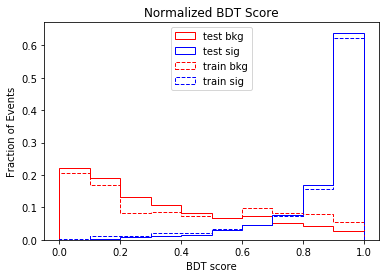

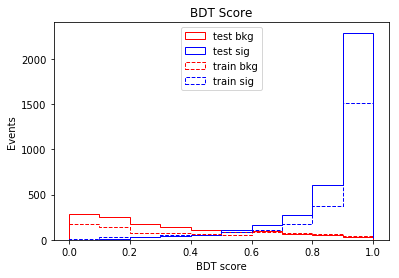

In [7]:
# Basic example: split source dataset into training and testing, train on training set, 
# evaluate on both testing and training set, and plot

train_DF, test_DF = train_test_split(DF, train_size=0.6, test_size=0.4, shuffle=True)

# START ------------------- Identical to TrainEval method -----------------------
# Create XGB object with the hyperparameters desired
xgb = XGBClassifier(n_estimators=200,
                    max_depth=3, 
                    min_child_weight=1,
                    seed=0)

# Fit to the training set, making sure to include event weights
xgb.fit(train_DF[["var1", "var2", "var3", "var4"]], # X
        train_DF["isSignal"], # y
        sample_weight=train_DF["weight"], # weights
       )

# Score the testing set
y_score_test = xgb.predict_proba(test_DF[var_list])[:,1] # predict_proba returns [prob_bkg, prob_sig] which have the property prob_bkg+prob_sig = 1 so we only need one. Chose signal-ness

# Score the training set (for overtraining analysis)
y_score_train = xgb.predict_proba(train_DF[var_list])[:,1] # predict_proba returns [prob_bkg, prob_sig] which have the property prob_bkg+prob_sig = 1 so we only need one. Chose signal-ness

# Cast the scores into pandas Series in order to connect their index to the source index
y_score_test = pd.Series(y_score_test, index=test_DF.index) 
y_score_train = pd.Series(y_score_train, index=train_DF.index) 
# END ------------------- Identical to TrainEval method -----------------------

PlotTemplate(test_DF, train_DF, y_score_test, y_score_train)
PlotTemplate(test_DF, train_DF, y_score_test, y_score_train, norm=False)

In [8]:
# Parameter sweeping example: fit multiple sets of hyperparameters and record their performance for plotting
# See GridSearchCV for scikit-learn packaged version of this functionality 
# (note -- 0.19 for scikit-learn does not support multiple scores, which means this must be rerun for each score 
# to investigate)

# Results will be stored as lists of pairs (mean, std) for each hyperparameter set
results_train = {"loss":[], "acc": [], "auc": []}
results_test = {"loss":[], "acc": [], "auc": []}

# Create our training / testing split
train_DF, test_DF = train_test_split(DF, train_size=0.6, test_size=0.4, shuffle=True)

# While sweeping our hyperparameters, we want to track the best result for plotting in the end
best_score = -999

# Select some values of n_estimators to check, and lock the other hyperparameters
max_depth = 3
min_child_weight = 5
x = range(5,105,5) + range(110,210,10) + range(300,1100,100)
for i, n_est in enumerate(x):

    # Lazy progress bar
    print n_est,
    
    # Calculate scores for this set of hyperparameters
    y_score_train, y_score_test = TrainEval(train_DF, 
                                            test_DF, 
                                            var_list, 
                                            n_estimators=n_est, 
                                            max_depth=max_depth,
                                            min_child_weight=min_child_weight,
                                            seed=0)

    # Record all the goodies from this iteration for plotting later. 
    # Each entry is a pair of values (mean, std). 
    # In this case, only record a single value with no std.
    results_test["loss"].append( (log_loss(test_DF["isSignal"], y_score_test, sample_weight=test_DF["weight"]),0) )
    results_train["loss"].append( (log_loss(train_DF["isSignal"], y_score_train, sample_weight=train_DF["weight"]),0) )
    results_test["acc"].append( (accuracy_score(test_DF["isSignal"], (y_score_test+0.5).astype(int), sample_weight=test_DF["weight"]),0) )
    results_train["acc"].append( (accuracy_score(train_DF["isSignal"], (y_score_train+0.5).astype(int), sample_weight=train_DF["weight"]),0) )
    results_test["auc"].append( (roc_auc_score(test_DF["isSignal"], y_score_test, sample_weight=test_DF["weight"]),0) )
    results_train["auc"].append( (roc_auc_score(train_DF["isSignal"], y_score_train, sample_weight=train_DF["weight"]),0) )
    
    # Using our chosen "best" metric, we will keep track of the best set of hyperparameters here
    # We could have a more advance metric for early stopping here, such as demanding a stop if 
    # the score doesn't improve n times in a row, or a minimum required improvement,
    # but for now we won't worry about it
    if results_test["auc"][i][0] > best_score:
        best_score = results_test["auc"][i][0] # test[auc][n_estimators][mean]
        print "New high score!: {:4.4f}".format(best_score)
        best_train_DF = train_DF
        best_test_DF = test_DF
        best_y_score_train = y_score_train
        best_y_score_test = y_score_test
        best_params = {"n_estimators":n_est, "max_depth": max_depth, "min_child_weight": max_depth}
    else:
        print "Not improved"
    
print "" # consequence of the lazy progress bar

# Numpy arrays are easier to manipulate than lists
for k in results_test.keys():
    results_test[k] = np.array(results_test[k])
    results_train[k] = np.array(results_train[k])

5 New high score!: 0.8382
10 New high score!: 0.8485
15 New high score!: 0.8547
20 New high score!: 0.8614
25 New high score!: 0.8650
30 New high score!: 0.8705
35 New high score!: 0.8765
40 New high score!: 0.8826
45 New high score!: 0.8854
50 New high score!: 0.8889
55 New high score!: 0.8929
60 New high score!: 0.8955
65 New high score!: 0.8971
70 New high score!: 0.8984
75 New high score!: 0.8999
80 New high score!: 0.9013
85 New high score!: 0.9026
90 New high score!: 0.9036
95 New high score!: 0.9045
100 New high score!: 0.9052
110 New high score!: 0.9069
120 New high score!: 0.9081
130 New high score!: 0.9090
140 New high score!: 0.9096
150 New high score!: 0.9098
160 New high score!: 0.9103
170 New high score!: 0.9107
180 New high score!: 0.9109
190 Not improved
200 New high score!: 0.9110
300 New high score!: 0.9115
400 Not improved
500 Not improved
600 Not improved
700 Not improved
800 Not improved
900 Not improved
1000 Not improved



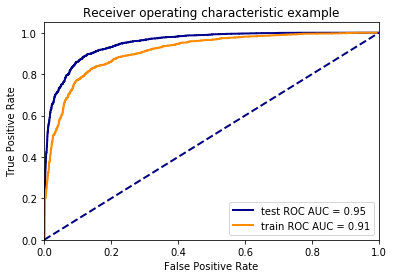

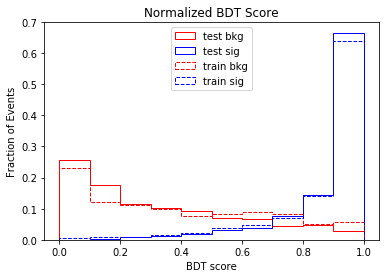

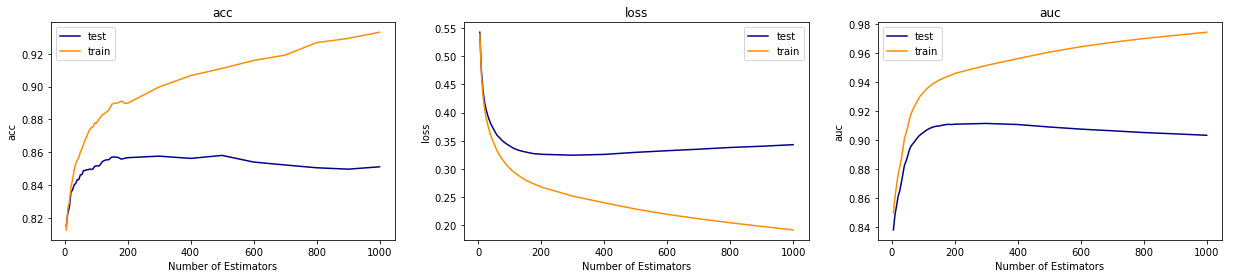

In [ ]:
# Now plot everything we have for our best estimator
PlotROC(best_test_DF, best_train_DF, best_y_score_test, best_y_score_train)
PlotTemplate(best_test_DF, best_train_DF, best_y_score_test, best_y_score_train)

# Also plot our parameter sweep
PlotBehavior(x, results_train, results_test, plot_err=False)


In [ ]:
# Now let us improve our training/testing split! Instead of just splitting our set, 
# let us use KFold cross-validation.
# We will split the set into N/k sized splits, which we will then permute k times
# into training and testing sets, never allowing the sets to overlap.

# Results will be stored as lists of pairs (mean, std) for each hyperparameter set
results_train = {"loss":[], "acc": [], "auc": []}
results_test = {"loss":[], "acc": [], "auc": []}

# Instead of a simple split, we here initialize a StratifiedKFold object to shuffle and split
skf = StratifiedKFold(n_splits=3, shuffle=True)

# While sweeping our hyperparameters, we want to track the best result for plotting in the end
best_score = -999

# Select some values of n_estimators to check, and lock the other hyperparameters
max_depth = 3
min_child_weight = 5
x = range(5,105,5) + range(110,210,10) + range(300,1100,100)
for i,n_est in enumerate(x):
    
    # Lazy progress bar
    print n_est,
    
    # We will now have k results per set of hyperparameters, to average in the end
    this_result_train = {"loss":[], "acc": [], "auc": []}
    this_result_test  = {"loss":[], "acc": [], "auc": []}
    
    for train_index, test_index in skf.split(DF, DF["isSignal"]):


        train_DF = DF.iloc[train_index]
        test_DF = DF.iloc[test_index]    
        
        y_score_train, y_score_test = TrainEval(train_DF, 
                                                test_DF, 
                                                var_list, 
                                                n_estimators=n_est, 
                                                max_depth=max_depth,
                                                min_child_weight=max_depth,
                                                seed=0)

        # Record all the goodies from this iteration for plotting later
        this_result_test["loss"].append(log_loss(test_DF["isSignal"], y_score_test, sample_weight=test_DF["weight"]))
        this_result_train["loss"].append(log_loss(train_DF["isSignal"], y_score_train, sample_weight=train_DF["weight"]))    
        this_result_test["acc"].append(accuracy_score(test_DF["isSignal"], (y_score_test+0.5).astype(int), sample_weight=test_DF["weight"]))
        this_result_train["acc"].append(accuracy_score(train_DF["isSignal"], (y_score_train+0.5).astype(int), sample_weight=train_DF["weight"]))    
        this_result_test["auc"].append(roc_auc_score(test_DF["isSignal"], y_score_test, sample_weight=test_DF["weight"]))
        this_result_train["auc"].append(roc_auc_score(train_DF["isSignal"], y_score_train, sample_weight=train_DF["weight"]))    
    
    # Replace our recorded lists with a mean and standard deviation pair
    results_test["loss"].append((np.mean(this_result_test["loss"]), np.std(this_result_test["loss"])) )
    results_train["loss"].append((np.mean(this_result_train["loss"]), np.std(this_result_train["loss"])) )
    results_test["acc"].append((np.mean(this_result_test["acc"]), np.std(this_result_test["acc"])) )
    results_train["acc"].append((np.mean(this_result_train["acc"]), np.std(this_result_train["acc"])) )
    results_test["auc"].append((np.mean(this_result_test["auc"]), np.std(this_result_test["auc"])) )
    results_train["auc"].append((np.mean(this_result_train["auc"]), np.std(this_result_train["auc"])) )
    
    # Using our chosen "best" metric, we will keep track of the best set of hyperparameters here
    # We could have a more advance metric for early stopping here, such as demanding a stop if 
    # the score doesn't improve n times in a row, or a minimum required improvement,
    # but for now we won't worry about it
    if results_test["auc"][i][0] > best_score:
        best_score = results_test["auc"][i][0] # test[auc][n_estimators][mean]
        print "New high score!: {:4.4f}".format(best_score)
        best_train_DF = train_DF
        best_test_DF = test_DF
        best_y_score_train = y_score_train
        best_y_score_test = y_score_test
        best_params = {"n_estimators":n_est, "max_depth": max_depth, "min_child_weight": max_depth}
    else:
        print "Not improved"
        
print "" # consequence of the lazy progress bar

# Numpy arrays are easier to manipulate than lists
for k in results_test.keys():
    results_test[k] = np.array(results_test[k])
    results_train[k] = np.array(results_train[k])

5 New high score!: 0.8371
10 New high score!: 0.8427
15 New high score!: 0.8546
20 New high score!: 0.8571
25 New high score!: 0.8652
30 New high score!: 0.8683
35 New high score!: 0.8752
40 New high score!: 0.8808
45 New high score!: 0.8836
50 New high score!: 0.8879
55 New high score!: 0.8906
60 New high score!: 0.8926
65 New high score!: 0.8956
70 New high score!: 0.8972
75 New high score!: 0.8999
80 Not improved
85 New high score!: 0.9042
90 Not improved
95 Not improved
100 Not improved
110 New high score!: 0.9068
120 New high score!: 0.9072
130 New high score!: 0.9074
140 New high score!: 0.9096
150

In [ ]:
# Now plot everything we have for our best estimator
PlotROC(best_test_DF, best_train_DF, best_y_score_test, best_y_score_train)
PlotTemplate(best_test_DF, best_train_DF, best_y_score_test, best_y_score_train)

# Also plot our parameter sweep
PlotBehavior(x, results_train, results_test, plot_err=True, plot_vertical=True)